## Introduction
[simple-exploration-baseline-notebook-avito](https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-notebook-avito)

avitoはロシアで最も大きな広告サイト，課題は商品の情報(画像，説明，タイトル)，コンテキスト(掲載された場所，すでに掲載された類似の広告)，および類似の広告の過去の需要に基づいてオンライン広告の需要を予測することが目的．

基本的に情報はロシア語なので，翻訳したりする必要あるかも．

### reference

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

## check dataset

In [2]:
from subprocess import check_output
print(check_output(['ls', '/Users/tela/.kaggle/competitions/avito-demand-prediction']).decode('utf-8'))

periods_test.csv
periods_train.csv
sample_submission.csv
test.csv
test_active.csv
test_jpg.zip
train.csv
train_active.csv.zip
train_jpg.zip



- train.csv - 学習データ
- test.csv - テストデータ，学習データから需要の確率が引かれている
- train_active.csv - train.csvと同じ期間に表示された広告の追加データ
- test_active.csv - test.csvと同じ期間に表示された広告の追加データ
- periods_train.csv - train_active.csvの広告が有効になった日付と表示された日付を示す追加データ
- periods_test.csv - test_active.csvの広告が有効になった日付と表示された日付を示す追加データ
- train_jpg.zip - train.csvの画像データ
- test_jpg.zip - test.csvの画像データ
- sample_submission.csv - 提出ファイルの正しいフォーマット

In [3]:
train_df = pd.read_csv("~/.kaggle/competitions/avito-demand-prediction/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("~/.kaggle/competitions/avito-demand-prediction/test.csv", parse_dates=["activation_date"])

In [4]:
print(train_df.columns)

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')


- item_id - Ad id.
- user_id - User id.
- region - Ad region.
- city - Ad city.
- parent_category_name - Top level ad category as classified by Avito's ad model.
- category_name - Fine grain ad category as classified by Avito's ad model.
- param_1 - Optional parameter from Avito's ad model.
- param_2 - Optional parameter from Avito's ad model.
- param_3 - Optional parameter from Avito's ad model.
- title - Ad title.
- description - Ad description.
- price - Ad price.
- item_seq_number - Ad sequential number for user.
- activation_date- Date ad was placed.
- user_type - User type.
- image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
- image_top_1 - Avito's classification code for the image.
- deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

In [5]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


予測する値を眺め見る

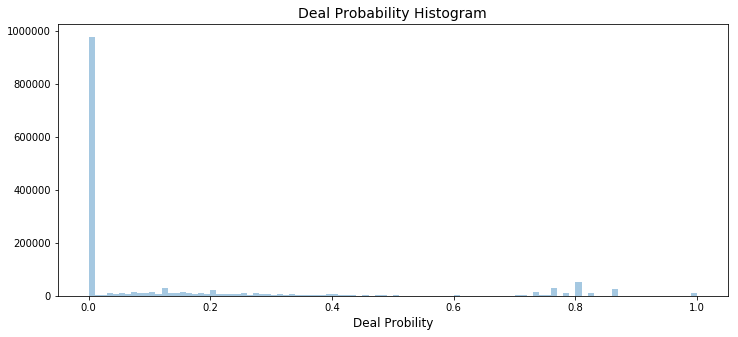

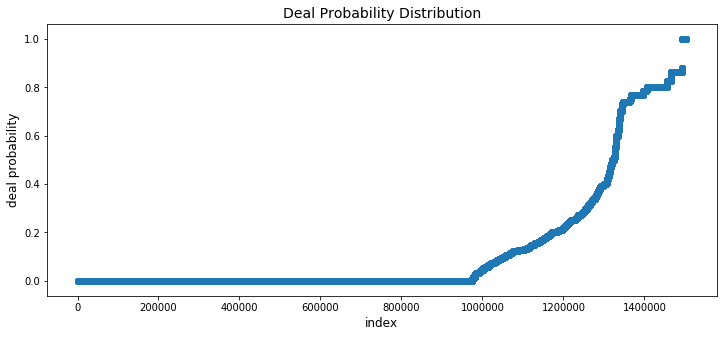

In [6]:
plt.figure(figsize=(12,5))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(12,5))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

**広告の地域別分布**

ロシア語をアルファベットに変換

In [7]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [8]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=700,
    height=500,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

1. クラスノダール地方 - 9.41%
2. スヴェルドロフスク州 - 6.28%
3. ロストフ州 - 5.99%

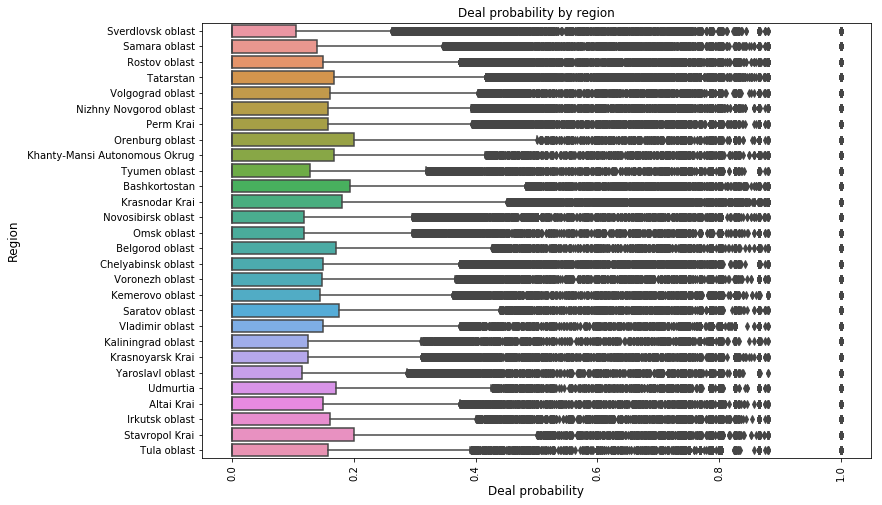

In [9]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

**広告の都市別分布**

上位20の都市

In [10]:
cnt_srs = train_df['city'].value_counts().head(20)
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='City distribution of Ads',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CityAds")

1. Krasnodar(クラスノダール)
2. Ekaterinburg(エカテリンブルク)
3. Novosibirsk(ノヴォシビルスク)

**親カテゴリ別**

In [11]:
temp_data = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

In [12]:
temp_series = train_df['parent_category_name_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Parent Category distribution',
    width=700,
    height=500,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory")

1. Personal belongings(個人の所持品)
2. Fot the home and garden(家庭，庭用)
3. Consumer electronics(電化製品)

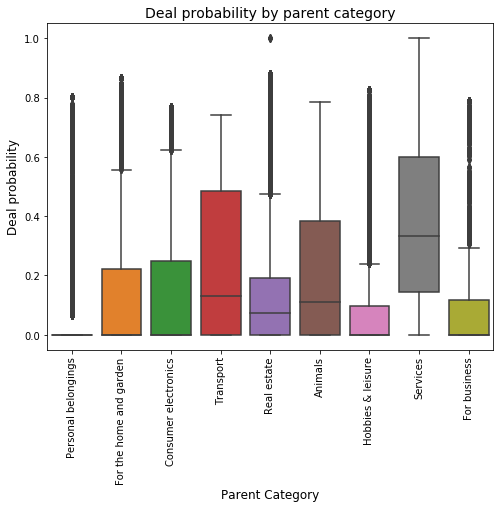

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(x="parent_category_name_en", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

サービスカテゴリーは他のものよりわずかに需要確率が高くなる

**広告のカテゴリー**

In [14]:
temp_data = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="category_name", how="left")

In [15]:
cnt_srs = train_df['category_name_en'].value_counts()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Category Name of Ads - Count',
    height=900
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="category name")

1. 衣服，靴，アクセサリー
2. 子供服，および靴
3. 子供用品とおもちゃ

**ユーザーの種類**

In [16]:
temp_series = train_df['user_type'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='User Type distribution',
    width=400,
    height=300,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

**金額**

広告に表示される金額

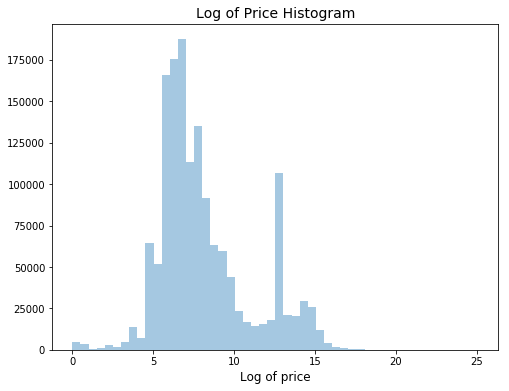

In [17]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"] = train_df["price_new"].fillna(np.nanmean(train_df["price"].values))

plt.figure(figsize=(8,6))
sns.distplot(np.log1p(train_df["price_new"].values), kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

**Activation Date**

In [18]:
cnt_srs = train_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Train'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

# Activation dates in test
cnt_srs = test_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Test'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

訓練データ(2週間)
2017/3/15(水)~3/28

テストデータ(1週間)
2017/4/12(水)~4/18

曜日が特徴量として使えるかも？

**ユーザー**

訓練データとテストデータの共通の数をみる

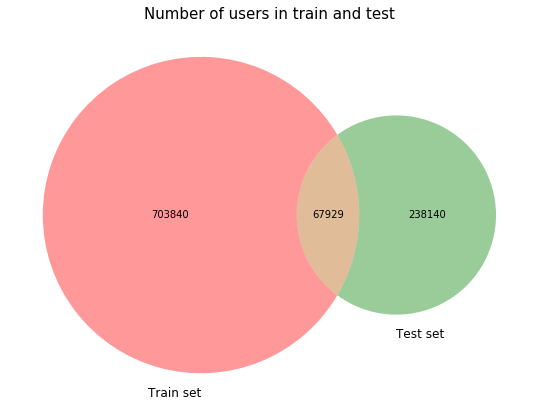

In [19]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_df.user_id.unique()), set(test_df.user_id.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of users in train and test", fontsize=15)
plt.show()

**Title**

訓練データとテストデータの共通の数をみる

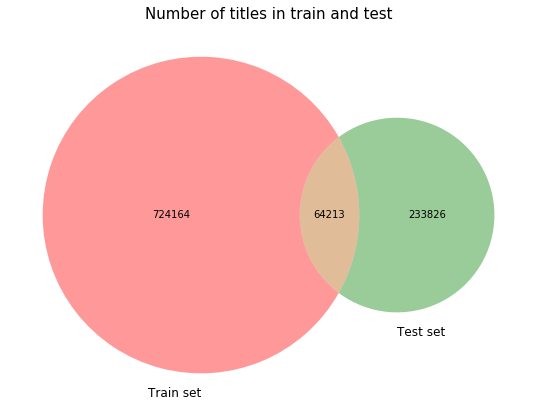

In [20]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_df.title.unique()), set(test_df.title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of titles in train and test", fontsize=15)
plt.show()

共通のタイトルは64k，

タイトル欄にある単語の数を調べる

In [21]:
train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
test_df["title_nwords"] = test_df["title"].apply(lambda x: len(x.split()))

cnt_srs = train_df['title_nwords'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords")  

ほとんどのタイトルは1~3語使われている．

タイトルを特徴量に変換したい

1. タイトルのTF-IDFをとると巨大な次元を持つ疎な行列になる
2. TF-IDFのSVDコンポーネントを入手
3. 需要の確率でSVDコンポーネントの分布をプロットすることで，有効な特徴量になるかどうかを確認

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [23]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['title'].values.tolist() + test_df['title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['title'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

<Figure size 432x432 with 0 Axes>

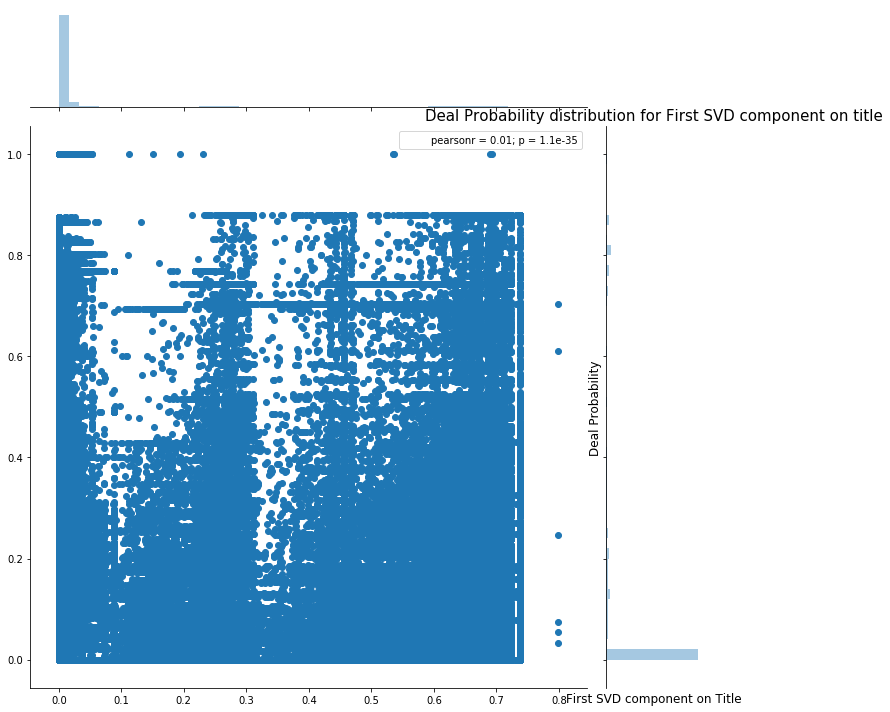

<Figure size 432x432 with 0 Axes>

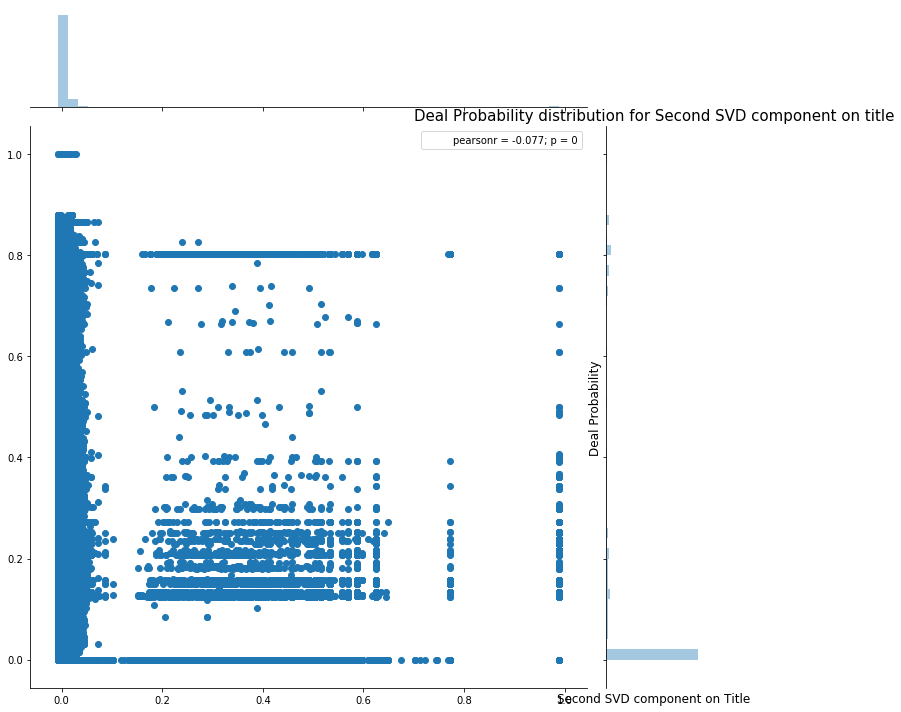

<Figure size 432x432 with 0 Axes>

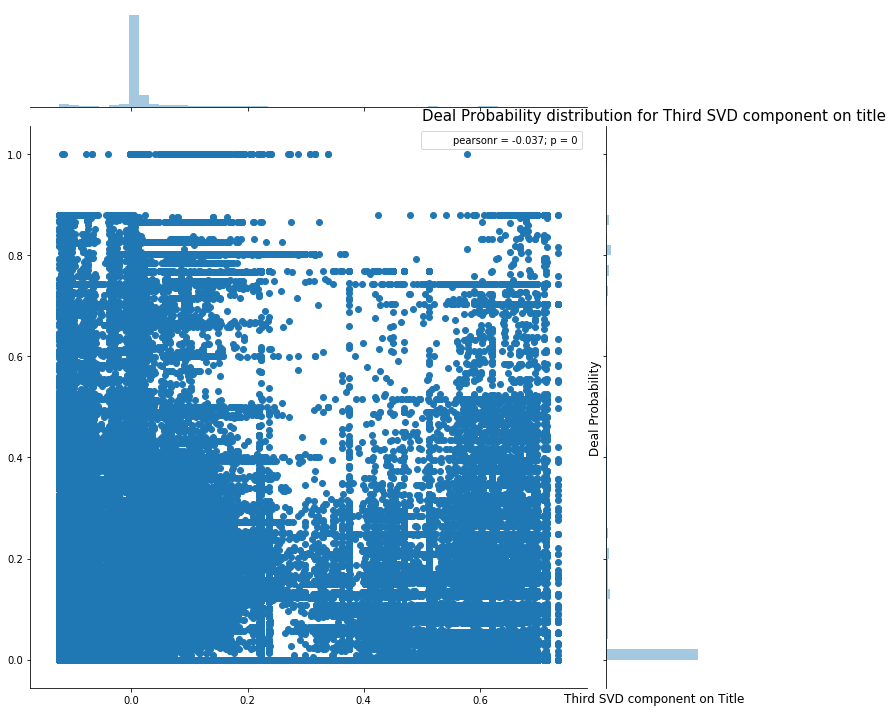

In [24]:
# 1st svd comp #
plt.figure(figsize=(6, 6))
sns.jointplot(x=train_df["svd_title_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on title", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(6,6))
sns.jointplot(x=train_df["svd_title_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(6,6))
sns.jointplot(x=train_df["svd_title_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Third SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on title", fontsize=15)
plt.show()

上位のSVDコンポーネントはデータのかなりの量をキャプチャします

**Description**

descriptionについても単語数を調べる

In [25]:
train_df["description"] = train_df["description"].fillna("NA")
test_df["description"] = test_df["description"].fillna("NA")

train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))
test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(x.split()))

cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")

descriptionの単語数は多いもので，700語あるがここでは省略．

タイトルと同じようにSVDコンポーネントを作る

In [26]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
full_tfidf = tfidf_vec.fit_transform(train_df['description'].values.tolist() + test_df['description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['description'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

<Figure size 432x432 with 0 Axes>

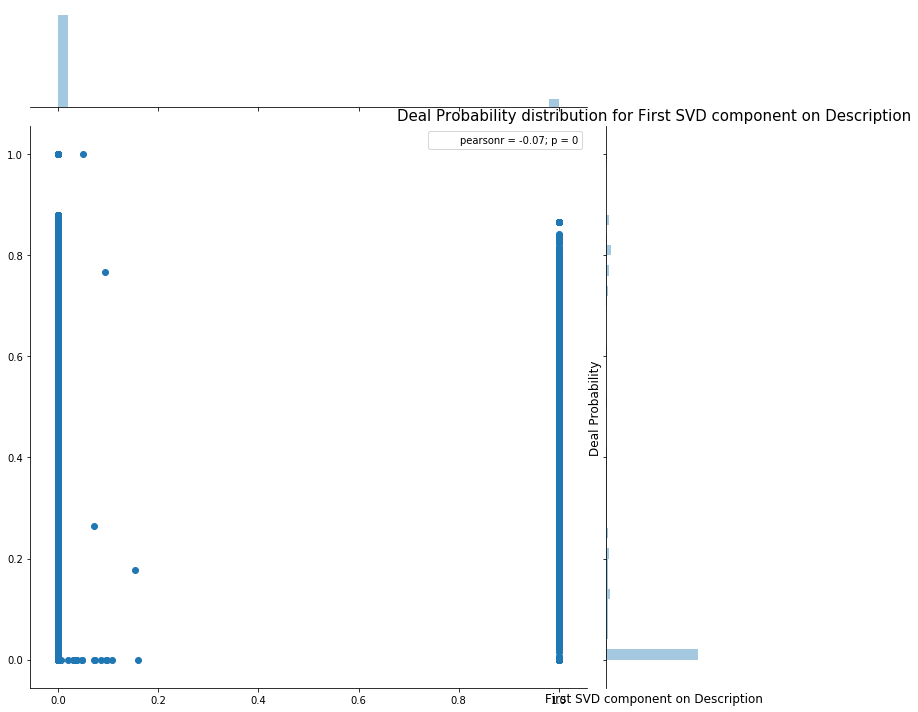

<Figure size 432x432 with 0 Axes>

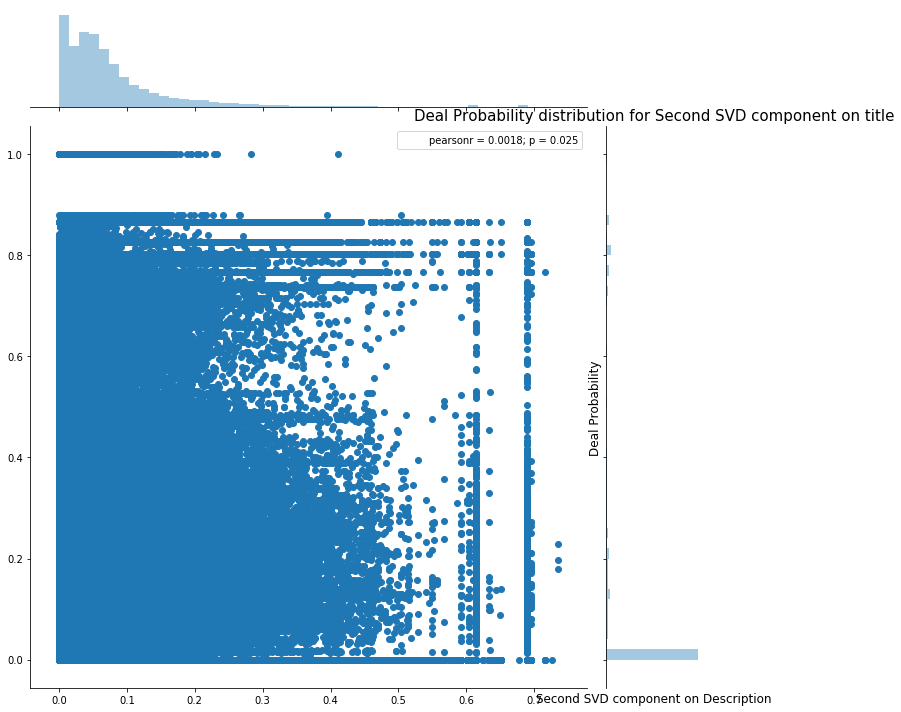

<Figure size 432x432 with 0 Axes>

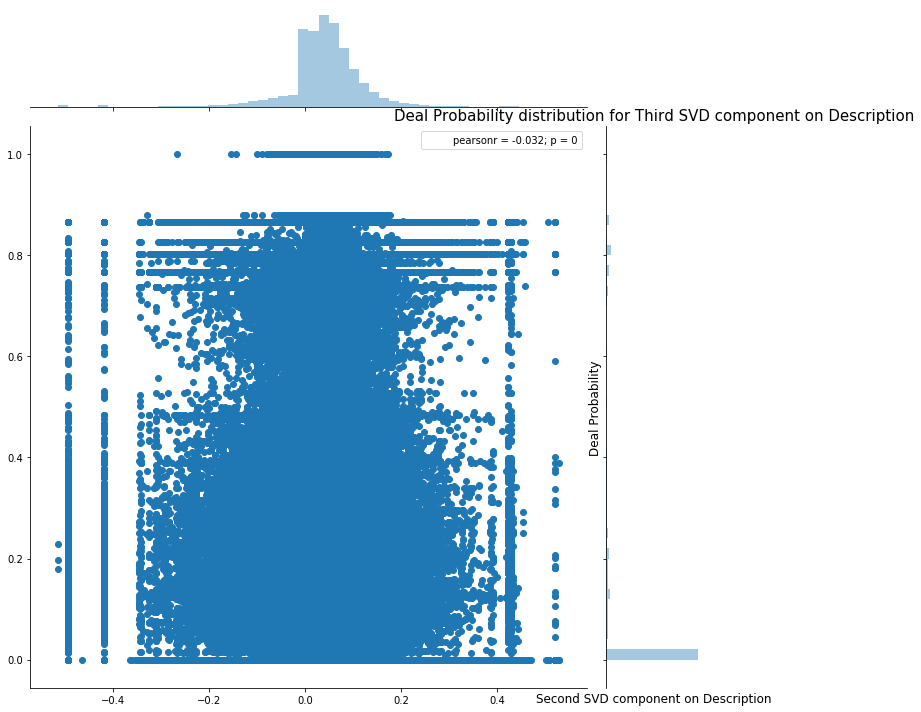

In [27]:
# 1st svd comp #
plt.figure(figsize=(6,6))
sns.jointplot(x=train_df["svd_desc_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on Description", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(6,6))
sns.jointplot(x=train_df["svd_desc_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(6,6))
sns.jointplot(x=train_df["svd_desc_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on Description", fontsize=15)
plt.show()

**Baseline Model**

先ほど見た特徴量を作成し，簡単なモデルを試す

*feature engineering*

In [28]:
from sklearn import preprocessing, model_selection, metrics

In [29]:
# Target and ID variables #
train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

# # Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_df.drop(cols_to_drop + ["region_en", "parent_category_name_en", "category_name_en", "price_new", "deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

*modeling*
LightGBM modelの作成

インストールはgithub参考に
- https://github.com/Microsoft/LightGBM/tree/master/python-package

In [30]:
import lightgbm as lgb

In [31]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [32]:
# Splitting the data for model training#
dev_X = train_X.iloc[:-200000,:]
val_X = train_X.iloc[-200000:,:]
dev_y = train_y[:-200000]
val_y = train_y[-200000:]
print(dev_X.shape, val_X.shape, test_X.shape)

# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

(1303424, 20) (200000, 20) (508438, 20)
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.235965
[40]	valid_0's rmse: 0.2329
[60]	valid_0's rmse: 0.231584
[80]	valid_0's rmse: 0.230662
[100]	valid_0's rmse: 0.230074
[120]	valid_0's rmse: 0.229647
[140]	valid_0's rmse: 0.229247
[160]	valid_0's rmse: 0.228858
[180]	valid_0's rmse: 0.228614
[200]	valid_0's rmse: 0.2284
[220]	valid_0's rmse: 0.228199
[240]	valid_0's rmse: 0.228067
[260]	valid_0's rmse: 0.227882
[280]	valid_0's rmse: 0.227766
[300]	valid_0's rmse: 0.227677
[320]	valid_0's rmse: 0.227572
[340]	valid_0's rmse: 0.227459
[360]	valid_0's rmse: 0.227362
[380]	valid_0's rmse: 0.227266
[400]	valid_0's rmse: 0.22718
[420]	valid_0's rmse: 0.22706
[440]	valid_0's rmse: 0.22699
[460]	valid_0's rmse: 0.226908
[480]	valid_0's rmse: 0.226801
[500]	valid_0's rmse: 0.226752
[520]	valid_0's rmse: 0.22668
[540]	valid_0's rmse: 0.226623
[560]	valid_0's rmse: 0.226582
[580]	valid_0's rmse: 0.22655
[600]	valid

**Feature Importance**

できたモデルの解析

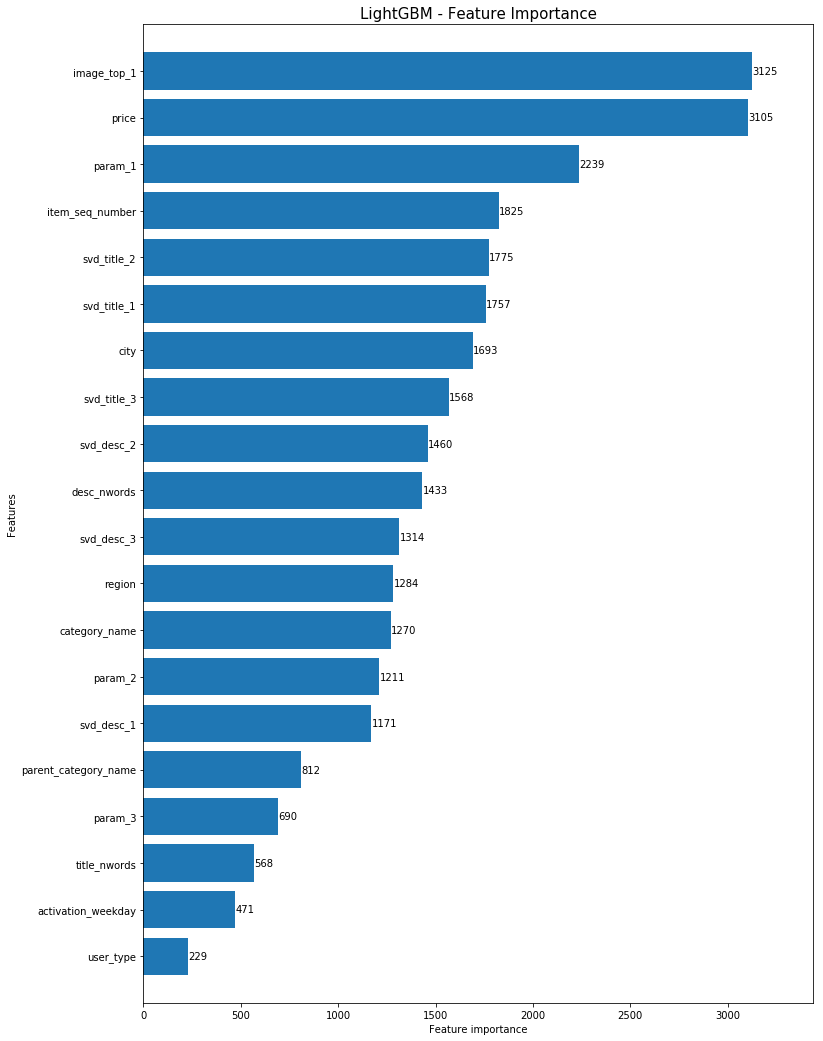

In [33]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

**Future work**
1. 新たな特徴を追加
2. パラメータのチューニング
3. 他のモデルと組み合わせる